In [28]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.combine import SMOTETomek
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, log_loss

In [23]:
#Load and preprocess data
def preprocess_data(data):
    # Separate features and target
    X = data.drop('custcat', axis=1)
    y = data['custcat']

    # Convert target to categorical
    le = LabelEncoder()
    y = le.fit_transform(y)

    # Handle missing values with iterative imputation
    imputer = SimpleImputer(strategy='mean')
    X_imputed = imputer.fit_transform(X)

    # Feature scaling
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_imputed)

    return X_scaled, y

In [24]:
# Feature engineering
def engineer_features(X, data):
    # Create interaction features
    X_df = pd.DataFrame(X, columns=data.drop('custcat', axis=1).columns)

    # Income per family member
    X_df['income_per_family'] = X_df['income'] / (X_df['marital'] + 1)

    # Age-based features
    X_df['age_squared'] = X_df['age'] ** 2
    X_df['income_age_ratio'] = X_df['income'] / X_df['age']

    # Education-income interaction
    X_df['education_income'] = X_df['ed'] * X_df['income']

    return X_df.values

In [25]:
# Advanced resampling with SMOTETomek
def balance_dataset(X, y):
    smote_tomek = SMOTETomek(sampling_strategy='auto', random_state=42)
    X_resampled, y_resampled = smote_tomek.fit_resample(X, y)
    return X_resampled, y_resampled

# Feature selection
def select_features(X, y):
    selector = SelectFromModel(
        RandomForestClassifier(n_estimators=100, random_state=42),
        max_features=10
    )
    return selector.fit_transform(X, y)

In [26]:
# Model training with hyperparameter tuning
def train_model(X_train, y_train):
    # Define models with parameter grids
    models = {
        'RandomForest': (
            RandomForestClassifier(random_state=42),
            {
                'n_estimators': [100, 200],
                'max_depth': [10, 15, 20],
                'min_samples_split': [2, 5],
                'min_samples_leaf': [1, 2],
                'class_weight': ['balanced', 'balanced_subsample']
            }
        ),
        'GradientBoosting': (
            GradientBoostingClassifier(random_state=42),
            {
                'n_estimators': [100, 200],
                'learning_rate': [0.05, 0.1],
                'max_depth': [3, 4, 5],
                'min_samples_split': [2, 4]
            }
        ),
        'LightGBM': (
            LGBMClassifier(random_state=42),
            {
                'n_estimators': [100, 200],
                'learning_rate': [0.05, 0.1],
                'max_depth': [3, 4, 5],
                'num_leaves': [31, 62]
            }
        )
    }

    best_score = 0
    best_model = None
    best_model_name = None

    for name, (model, param_grid) in models.items():
        print(f"\nTraining {name}...")
        grid_search = GridSearchCV(
            model,
            param_grid,
            cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
            scoring='f1_macro',
            n_jobs=-1
        )
        grid_search.fit(X_train, y_train)

        if grid_search.best_score_ > best_score:
            best_score = grid_search.best_score_
            best_model = grid_search.best_estimator_
            best_model_name = name

        print(f"{name} - Best F1-macro: {grid_search.best_score_:.4f}")
        print(f"Best parameters: {grid_search.best_params_}")

    return best_model, best_model_name


Training RandomForest...
RandomForest - Best F1-macro: 0.4971
Best parameters: {'class_weight': 'balanced', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}

Training GradientBoosting...
GradientBoosting - Best F1-macro: 0.4579
Best parameters: {'learning_rate': 0.05, 'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 200}

Training LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000154 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1039
[LightGBM] [Info] Number of data points in the train set: 675, number of used features: 9
[LightGBM] [Info] Start training from score -1.373049
[LightGBM] [Info] Start training from score -1.344229
[LightGBM] [Info] Start training from score -1.471288
[LightGBM] [Info] Start training from score -1.361421
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

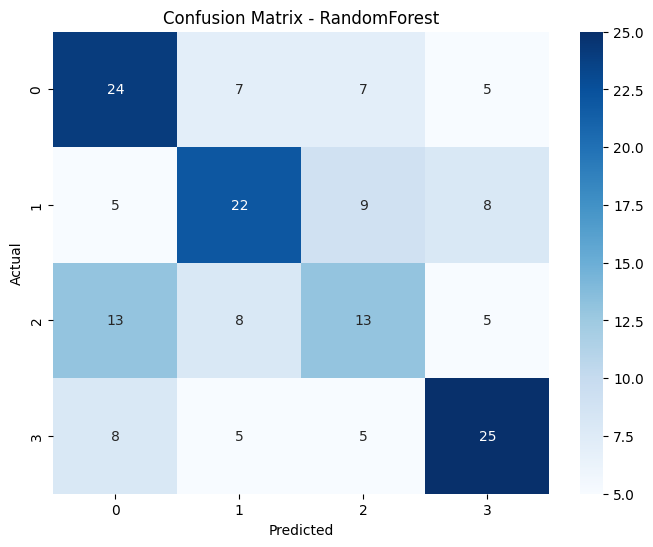

In [29]:
# Main execution
def main():
    # Load data
    data = pd.read_csv('teleCust1000t.csv')

    # Preprocess
    X_scaled, y = preprocess_data(data)

    # Engineer features
    X_engineered = engineer_features(X_scaled, data)

    # Select features
    X_selected = select_features(X_engineered, y)

    # Balance dataset
    X_balanced, y_balanced = balance_dataset(X_selected, y)

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X_balanced, y_balanced,
        test_size=0.2,
        random_state=42,
        stratify=y_balanced
    )

    # Train and evaluate
    best_model, best_model_name = train_model(X_train, y_train)

    # Final evaluation
    y_pred = best_model.predict(X_test)
    y_prob = best_model.predict_proba(X_test)

    print(f"\nBest model: {best_model_name}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    print(f"Log Loss: {log_loss(y_test, y_prob)}")

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    conf_matrix = confusion_matrix(y_test, y_pred)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix - {best_model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

if __name__ == "__main__":
    main()